In [15]:
import numpy
import scipy
from os.path import join
import matplotlib.pyplot as plt
import matplotlib
import colorsys
import texplot
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

# Moved to freealg
from freealg.visualization import rgb_hsv, glue_branches
from freealg.distributions import MarchenkoPastur, ChiralBlock, DeformedWigner, \
    DeformedMarchenkoPastur

from freealg import AlgebraicForm
from freealg._algebraic_form._sheets_util import track_roots_on_grid, infer_m1_partners_on_cuts
from freealg._algebraic_form._continuation_algebraic import eval_roots, build_sheets_from_roots

plot_dir = '.'

# Option 1. Marchenko-Pastur Model

* This has two sheets $s=2$ and one cut $k=1$.
* Corresponding compact geometry is a Riemann sphere $\mathbb{S}^2$.

In [16]:
filename = 'algebraic-mp'
title = 'Marchenko-Pastur Model'
sigma = 1.0
lam = 100 / 5000

mp = MarchenkoPastur(lam, sigma)
support = mp.support()
a1, b1 = support[0]

# Grid for MP
x_min, x_max = -0.5, 2.5
y_min, y_max = -1.0, 1.0

# def stieltjes(z):
#     return mp.stieltjes(z)

def density(x): 
    return mp.density(x)

# ---------

A = mp.matrix(4000)
# eigs = numpy.linalg.eigvalsh(A)
eigs = scipy.linalg.eigvalsh(A, lower=False, driver='ev')

def stieltjes(z):
    return numpy.mean(1.0/(eigs-z[:,numpy.newaxis]), axis=-1)

# Option 2. Bipartite Model

* This has two sheets $s=2$ and two cuts $k=2$.
* Corresponding compact geometry is a torus $\mathbb{T}^1$.

In [ ]:
filename = 'algebraic-bipartite'
title = 'Bipartite Model'
alpha = 0.40
beta = -0.70
c = 0.6

cb = ChiralBlock(alpha, beta, c)

# Support
support = cb.support()
a1, b1 = support[0]
a2, b2 = support[1]

# Grid for bipartite
x_min, x_max = -3.0, 3.0
y_min, y_max = -2.0, 2.0

def stieltjes(z):
    return cb.stieltjes(z, alt_branch=False)

def density(x):
    return cb.density(x)

# Option 3. Deformed Wigner Model

* This has three sheets $s=3$ and two cuts $k=2$.
* Corresponding compact geometry is still a Riemann sphere $\mathbb{S}^2$.

In [ ]:
filename = 'algebraic-deformed-wigner'
title = 'Deformed Wigner Model'
sigma = 1.0
t1 = -1.5
t2 = 2.5
w1 = 0.25


dwg = DeformedWigner(t1, t2, w1, sigma)

# Support
support = dwg.support()
a1, b1 = support[0]
a2, b2 = support[1]

# Grid
x_min = numpy.floor(min(a for a, b in support) - 1.0)
x_max = numpy.ceil(max(b for a, b in support) + 1.0)
y_min, y_max = -3.0, 3.0


def stieltjes(z):
    return dwg.stieltjes(z)

def density(x):
    return dwg.density(x, eta=1e-6)

def m_all_fn(z):
    return dwg.roots(z)

# Option 4. Deformed Marchenko-Pastur Model

* This has three sheets $s=3$ and two cuts $k=2$.
* Corresponding compact geometry is still a Riemann sphere $\mathbb{S}^2$.

In [2]:
filename = 'algebraic-deformed-mp'
title = 'Deformed Marchenko-Pastur Model'
c = 0.05
t1 = 2.0
t2 = 5.5
w1 = 0.75

dmp = DeformedMarchenkoPastur(t1, t2, w1, c)

# Support
support = dmp.support()
a1, b1 = support[0]
a2, b2 = support[1]

# Grid
x_min = numpy.floor(min(a for a, b in support) - 2.0)
x_max = numpy.ceil(max(b for a, b in support) + 2.0)
y_min, y_max = -3.0, 3.0

def stieltjes(z):
    return dmp.stieltjes(z)

def density(x):
    return dmp.density(x, eta=1e-6)

def m_all_fn(z):
    return dmp.roots(z)

# Plot Density

Plot saved to "/home/sia/work/scripts/free/Xperimental/Analytic Continuation/./algebraic-mp-density.pdf".


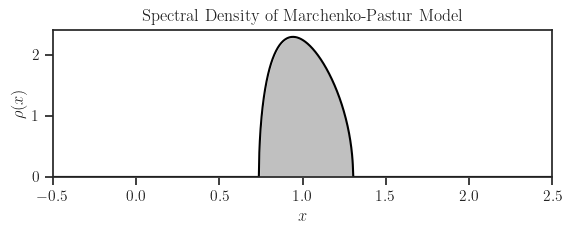

In [5]:
x = numpy.linspace(x_min, x_max, 2000)
rho = density(x)

with texplot.theme(rc={'font.family': 'serif'}, use_latex=True):
    fig, ax = plt.subplots(figsize=(6, 2.5))
    ax.plot(x, rho, color='black')
    ax.fill_between(x, y1=rho, facecolor='silver')

    ax.set_xlim([x_min, x_max])
    ax.set_ylim(bottom=0)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\rho(x)$')
    ax.set_title(r'Spectral Density of ' + title)

    plt.tight_layout()
    texplot.show_or_save_plot(plt, default_filename=join(plot_dir, filename +'-density.pdf'),
                              transparent_background=True, dpi=200,
                              show_and_save=True, verbose=True)

# Fit Stieltjes with Algebraic Surrogate

In [17]:
af = AlgebraicForm(stieltjes, support, delta=1e-5)

deg_m = 2
deg_z = 2
reg = 0.0

coeffs = af.fit(deg_m, deg_z, reg, normalize=True, triangular=None,
                verbose=True)

fit residual max: 0.0052130767912483235
fit residual 99.9%: 0.005144107663613211

Coefficinets
+9.4133+0.0000j -9.2262-0.0000j +0.0005-0.0000j 
-8.4133-0.0000j +17.6592+0.0000j +0.1877+0.0000j 
+0.0000+0.0000j -8.4133-0.0000j -0.1681-0.0000j 

Coefficients mangitudes
[[ 9.413251  9.226204  0.00045 ]
 [ 8.413251 17.659237  0.187657]
 [ 0.        8.413253  0.168117]]


# Free Decompression

In [18]:
# Query grid on the real axis + a small imaginary buffer
x = numpy.linspace(x_min, x_max, 1000)
t = numpy.linspace(0, 4, 30)

# Evolve
rho = af.decompress(x, t, sweep=True, verbose=True)

success rate per t: [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    0.999 0.998 1.    1.    1.    1.    0.999 1.    1.
 0.999 1.    1.    1.    1.    1.   ]


Plot saved to "/home/sia/work/scripts/free/Xperimental/Analytic Continuation/./algebraic-mp-decompress.pdf".


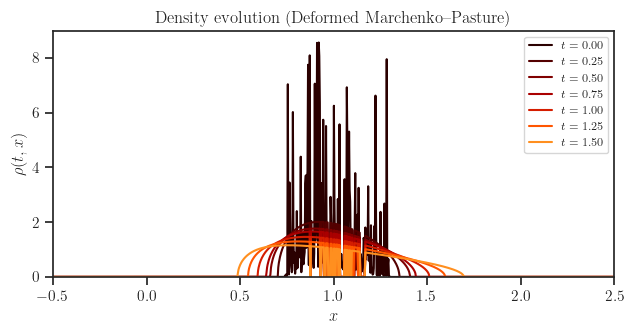

In [19]:
times_to_show = numpy.arange(0, 1.51, 0.25)
# times_to_show = nump[y.arange(0, 4, 0.25)
# times_to_show = numpy.arange(0, 0.2, 0.05)
idx = [int(numpy.argmin(numpy.abs(t - tt))) for tt in times_to_show]

num_plots = len(idx)
cmap = plt.get_cmap('gist_heat')
colors = [cmap(i/(num_plots + 2)) for i in range(num_plots + 1)][1:]

with texplot.theme(use_latex=True):
    
    fig, ax = plt.subplots(figsize=(6.5, 3.5))
    
    for i in range(len(idx)):
        ax.plot(x, rho[idx[i]], color=colors[i], label=rf'$t={{{times_to_show[i]:0.2f}}}$')

    ax.set_xlim([x[0], x[-1]])
    ax.set_ylim(bottom=0)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\rho(t, x)$')
    ax.set_title(r'Density evolution (Deformed Marchenko--Pasture)')
    plt.legend(fontsize='x-small')
    
    plt.tight_layout()
    texplot.show_or_save_plot(plt, default_filename=join(plot_dir, filename + '-decompress.pdf'),
                              transparent_background=True, dpi=200,
                              show_and_save=True, verbose=True)

# Free Edge

In [ ]:
t = numpy.linspace(0.0, 1.5, 100)
edges, active_k = af.edge(t, verbose=True)

In [ ]:
k = len(support)

colors = ['royalblue', 'maroon']
x = numpy.linspace(0, 12, 1000)

with texplot.theme(use_latex=True):
    
    fig, ax = plt.subplots(figsize=(6.5, 3.5))
    for j in range(k):
        a_t = edges[:, 2*j + 0]
        b_t = edges[:, 2*j + 1]
        ax.plot(a_t, t, color=colors[j], label=rf'$a_{{{j+1}}}(t), b_{{{j+1}}}(t)$')
        ax.plot(b_t, t, color=colors[j])

    ax.set_xlim([x[0], x[-1]])
    ax.set_ylim([t[0], t[-1]])
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$t$')
    ax.set_title(r'Evolution of Spectral Edges')
    ax.legend()
    plt.tight_layout()
    
    texplot.show_or_save_plot(plt, default_filename=join(plot_dir, filename + '-edge.pdf'),
                              transparent_background=True, dpi=200,
                              show_and_save=True, verbose=True)

# Plot Sheets

In [5]:
# Evaluate candidate sheets on a grid
# n_x = 1001
# n_y = 1000
n_x = 401 # TEST
n_y = 400

if n_y % 2 != 0:
    raise ValueError('n_y should be even.')

x = numpy.linspace(x_min, x_max, n_x)
y = numpy.linspace(y_min, y_max, n_y)

X, Y = numpy.meshgrid(x, y)
z = X + 1j * Y

m1 = stieltjes(z)

roots = eval_roots(z.ravel(), coeffs)

sheets, _ = build_sheets_from_roots(z, roots, m1, cuts=support)
m1 = sheets[0]
m2 = sheets[1]
m3 = sheets[2]

m_true_all = m_all_fn(z)
true_sheets = track_roots_on_grid(m_true_all, z=z)
m_true_1 = true_sheets[:, :, 0]
m_true_2 = true_sheets[:, :, 1]
m_true_3 = true_sheets[:, :, 2]

# m12_true = glue_branches(z, m1, m2_true)

# E = numpy.abs(m12 - m12_true)
# finite = numpy.isfinite(E)
# print("m12 finite max error:", numpy.max(E[finite]))
# print("m12 finite 99.9% error:", numpy.quantile(E[finite], 0.999))

In [6]:
# Paertners is a list like [1, 2] or [2, 1], indicating on the cut intervals I_1 and I_2,
# which of m2 or m3 is a partner to the physical branch m1. For example [2, 1] means
# [m3, m2] are the partners of m1 on [I_1, I_2].
partners = infer_m1_partners_on_cuts(z, [m1, m2, m3], support)

# When [m3, m2] is the partnet of m1 on [I_1, I_2], swap their position so that
# the natural order be like [m2, m3].
if partners == [2, 1]:
    # swap labels once
    m2, m3 = m3, m2 

true_partners = infer_m1_partners_on_cuts(z, [m_true_1, m_true_2, m_true_3], support)
if true_partners == [2, 1]:
    m_true_2, m_true_3 = m_true_3, m_true_2

# Glue sheets
m12 = glue_branches(z, m1, m2)
m13 = glue_branches(z, m1, m3)
m21 = glue_branches(z, m2, m1)
m31 = glue_branches(z, m3, m1)

Plot saved to "/home/sia/work/scripts/free/Xperimental/Analytic Continuation/./algebraic-deformed-mp-branches.pdf".


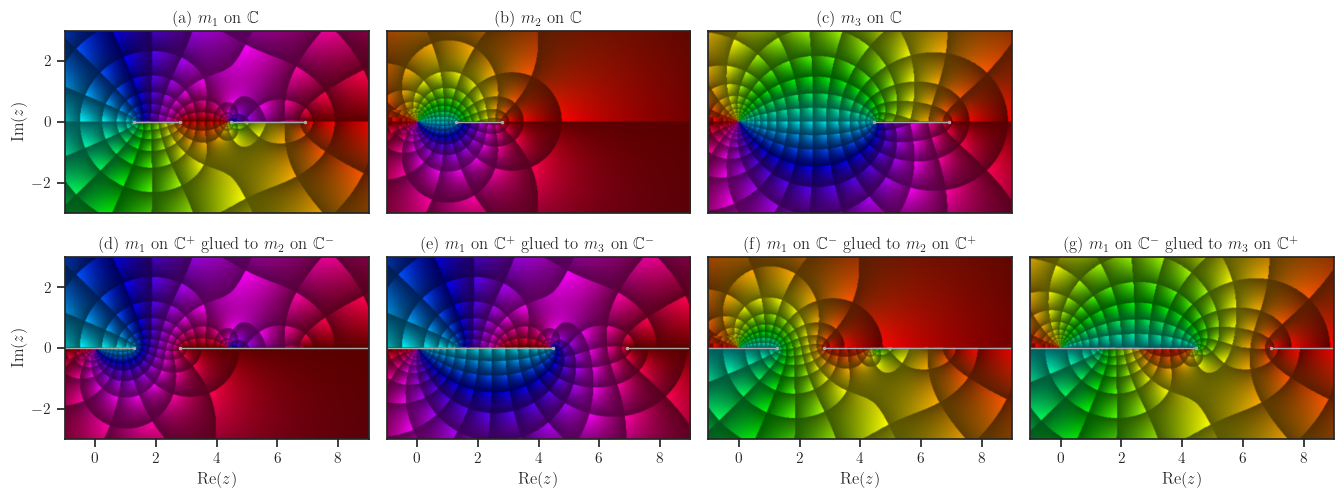

In [7]:
# =========
# plot axis
# =========

def plot_axis(ax, img, extent, x_ax=True, y_ax=True, bc='in', title=''):
    
    shift = 0.0
    ax.imshow(rgb_hsv(img, shift=shift, n_mod=18, n_ph=18, vmin=0.35, vmax=1.0, tile_gamma=0.9, tile_mix=1.0),
              extent=extent, origin='lower',
              interpolation='gaussian', rasterized=True)

    n_y = img.shape[0]
    eps = 2 / n_y

    bc_color = 'darkgray'
    if isinstance(bc, list):
        # Plot a line inside branch cut
        for bc_ in bc:
            a, b = support[bc_ - 1]
            ax.plot([a, b], [eps, eps], '-', linewidth=1, color=bc_color)
            ax.plot([a, b], [eps, eps], 'o', markersize=1.5, color=bc_color)
    elif bc < 0:
        # Plot lines out. These are not applicable for k-2, side of branch cut (complement of brnch cut)
        a, b = support[-bc - 1]
        ax.plot([x_min, a], [eps, eps], '-', linewidth=1, color=bc_color)
        ax.plot([b, x_max], [eps, eps], '-', linewidth=1, color=bc_color)
        ax.plot([a, b], [eps, eps], 'o', markersize=1.5, color=bc_color)

    ax.set_title(title)

    if x_ax is True:
        ax.set_xlabel(r'$\mathrm{Re}(z)$')
    if y_ax is True:
        ax.set_ylabel(r'$\mathrm{Im}(z)$')

    if x_ax is False:
        ax.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
    if y_ax is False:
        ax.tick_params(axis='y', left=False, right=False, labelleft=False)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])

# --------------------

extent = [x_min, x_max, y_min, y_max]

with texplot.theme(use_latex=True):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(13.6, 5), sharey=True)
    # fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(11, 8), sharey=True)
    
    # plot_axis(ax[0, 0], m_true_1, extent, x_ax=False, y_ax=True, bc=[1, 2], title=r'(a) $m_1$ on $\mathbb{C}$')
    # plot_axis(ax[0, 1], m_true_2, extent, x_ax=False, y_ax = False, bc=[1], title=r'(b) $m_2$ on $\mathbb{C}$')
    # plot_axis(ax[0, 2], m_true_3, extent, x_ax=False, y_ax = False, bc=[2], title=r'(c) $m_3$ on $\mathbb{C}$')

    plot_axis(ax[0, 0], m1, extent, x_ax=False, y_ax=True, bc=[1, 2], title=r'(a) $m_1$ on $\mathbb{C}$')
    plot_axis(ax[0, 1], m2, extent, x_ax=False, y_ax = False, bc=[1], title=r'(b) $m_2$ on $\mathbb{C}$')
    plot_axis(ax[0, 2], m3, extent, x_ax=False, y_ax = False, bc=[2], title=r'(c) $m_3$ on $\mathbb{C}$')
    ax[0, 3].axis('off')
    
    plot_axis(ax[1, 0], m12, extent, x_ax=True, y_ax=True, bc=-1, title=r'(d) $m_1$ on $\mathbb{C}^+$ glued to $m_2$ on $\mathbb{C}^-$')
    plot_axis(ax[1, 1], m13, extent, x_ax=True, y_ax=False, bc=-2, title=r'(e) $m_1$ on $\mathbb{C}^+$ glued to $m_3$ on $\mathbb{C}^-$')
    plot_axis(ax[1, 2], m21, extent, x_ax=True, y_ax=False, bc=-1, title=r'(f) $m_1$ on $\mathbb{C}^-$ glued to $m_2$ on $\mathbb{C}^+$')
    plot_axis(ax[1, 3], m31, extent, x_ax=True, y_ax=False, bc=-2, title=r'(g) $m_1$ on $\mathbb{C}^-$ glued to $m_3$ on $\mathbb{C}^+$')
    
    plt.tight_layout()

    texplot.show_or_save_plot(plt, default_filename=join(plot_dir, filename + '-branches.pdf'),
                              transparent_background=True, dpi=200,
                              show_and_save=True, verbose=True)